# credit anxiety index

this index combines objective market data with psychological indicators to detect *early signs of economic slowdown*.

## what is credit anxiety index?

an index that measures *financial tension* in the market by combining credit spread and public interest.

- *credit spread* — difference between yields on risky and safe bonds
- *public interest* — how many people actively search for information about credit problems

## why is it important?
during economic crises, investors become cautious, demand higher risk premium, and the public actively searches for information about financial problems.

## what is risk premium?

*risk premium* = additional return that investors require.

### example

| bond type | yield | risk |
|-----------|-------|------|
| government bonds (gs10) | 4% | low - government backed |
| corporate bonds (dbaa) | 6% | high - depends on corporation |
| risk premium | 2% | difference = compensation for risk |

### how it works:

investor says: "ok, i'll buy this riskier corporate bond, but i require *2% more* as compensation for the risk that the corporation might not pay back."

### premium dynamics  

when economy worsens:
- higher corporate bankruptcy risk
- investors demand higher premium
- spread rises (e.g. from 2% to 4%)

when stable:
- lower risk
- lower premium
- spread falls (e.g. from 4% back to 2%)


### in context of credit anxiety index
```
credit spread = dbaa - gs10 = credit risk premium
```


In [1]:
import urllib.request
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from pytrends.request import TrendReq

warnings.filterwarnings("ignore", category=FutureWarning)

today = pd.Timestamp('today').normalize()


### downloading data

*fred (federal reserve economic data)* is a database of the us federal reserve containing thousands of economic time series.

### we download:
- *gs10* - 10-year us treasury bonds
- *dbaa* - moody's seasoned baa corporate bond yield

In [2]:
today_str = dt.date.today().strftime("%Y-%m-%d")

url_dbaa = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id=DBAA&cosd=2020-01-01&coed={today_str}"
url_gs10 = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id=GS10&cosd=2020-01-01&coed={today_str}"

_=urllib.request.urlretrieve(url_dbaa, "DBAA.csv")
_=urllib.request.urlretrieve(url_gs10, "GS10.csv")

### gs10 (10-year treasury)
- gold standard of "risk-free" investment
- backed by us government
- during crises, investors flee to safety, yield falls


### dbaa (baa corporate bonds)
- bonds from corporations with *lower credit rating* (baa/bbb)
- considered *riskier* than government bonds
- when economy weakens, investors demand higher premium for taking risk, yield rises

In [3]:
dbaa = (pd.read_csv("DBAA.csv",
                    parse_dates=['observation_date'],
                    date_format='%m/%d/%y')  
          .rename(columns={'DBAA':'rate'}))

gs10 = (pd.read_csv("GS10.csv",
                    parse_dates=['observation_date'],
                    date_format='%m/%d/%y')
          .rename(columns={'GS10':'rate'}))

# zadnji dostupni dan
r_dbaa = dbaa.dropna().iloc[-1]
r_gs10 = gs10.dropna().iloc[-1]

spread = float(r_dbaa.rate) - float(r_gs10.rate)
print(f"DBAA: {r_dbaa.rate} % | GS10: {r_gs10.rate} % | Spread: {spread:.2f} %")

DBAA: 5.84 % | GS10: 4.06 % | Spread: 1.78 %


### what is credit spread?

#### credit spread = dbaa - gs10

*spread shows credit risk premium:*

| spread | status | description |
|--------|--------|-------------|
| **~1-2%** | low | investors relaxed, willing to take risk, stable economy |
| **2-3%** | moderate | increased caution, first concerns about creditworthiness |
| **>4%** | high | panic, investors fleeing risky bonds, possible recession signs |

*historical context:*
- normal times (2015-2019): ~2%
- covid crisis (march 2020): ~4%
- financial crisis (2008-2009): ~6%

*why does spread widen during crises?*

when economy weakens:
1. corporations face higher bankruptcy probability → investors sell corporate bonds → dbaa rises
2. investors seek safety → buy treasury bonds → gs10 falls
3. *result*: spread explodes


In [4]:
#pip install pytrends 


### fetching google trends data

we track how many people search for *"credit crunch"* - an indicator of public concern.

*why measure public interest in "credit crunch"?*

**credit crunch** = situation when banks suddenly reduce credit availability

### market psychology:
- when economy turns down, people start googling "credit crunch", "recession", "layoffs"
- *rise in searches = rise in concern* = possible early problem signal
- sometimes public senses problems *before they appear in official data*

### google trends scoring:

| value | status |
|-------|--------|
| **<20** | low concern |
| **20-50** | moderate concern |
| **>50** | high concern, something is happening |

*why 3 months?*
`timeframe='today 3-m'` is short enough to catch trends, long enough to avoid noise.

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(["credit crunch"], timeframe='today 3-m')
trend_df = pytrends.interest_over_time()
gt = trend_df["credit crunch"].iloc[-1]
print("Google Trends:", gt)

Google Trends: 34


### calculating anxiety index

we combine credit spread and public interest:

#### formula
```
anxiety index = credit spread + (google trends / 100)
```

- *credit spread*: objective measure of market risk
- *google trends*: subjective measure of public perception


*why this combination?*

| component | type | weight | description |
|-----------|------|--------|-------------|
| **credit spread** | objective | ~1.5-6 points | based on real market transactions |
| **google trends / 100** | subjective | ~0.2-1 point | captures psychological trends and perception |

*example:*
- spread = 2.5%
- google trends = 40
- *index = 2.5 + 0.4 = 2.9* → moderate tension

In [7]:
index = spread + gt/100
row   = pd.DataFrame([{"observation_date": today, "dbaa": r_dbaa.rate, "gs10": r_gs10.rate,
                       "spread": spread, "gtrend": gt, "anxiety_index": index}])


### saving and visualization

adding new data point and displaying trend.

In [8]:
try: hist = pd.read_csv("anxiety.csv", parse_dates=["observation_date"])
except: hist = pd.DataFrame()
hist  = pd.concat([hist, row]).drop_duplicates(subset=["observation_date"])
hist.to_csv("anxiety.csv", index=False)
print("Zadnji index:", round(index,2))

Zadnji index: 2.12


## interpretation of results

| index | status | economic situation |
|-------|--------|-------------------|
| **< 2** | calm market | stable economy, low risk premium, relaxed investors |
| **2-4** | moderate tension | increased caution, first concerns, expensive credit |
| **> 4** | high stress | serious crisis, panicked investors, possible recession signal |

### what does rising index mean?

*for corporations:*
- more expensive borrowing → less investment
- difficult access to capital → business slowdown
- lower profit → possible layoffs

*for investors:*
- "flight to quality" → fleeing to safe bonds
- higher market volatility
- panic selling of risky assets

*for economy:*
- early sign of slowdown before it appears in gdp
- reduced lending → less consumption
- self-fulfilling prophecy: fear → less investment → recession

### historical context

| event | spread | index | outcome |
|-------|--------|-------|---------|
| **2008 financial crisis** | ~6% | ~6.5 | severe recession |
| **2020 covid** | ~4% | ~4.3 | quick recovery with fed intervention |
| **2025** | ~2% | ~2 | relatively calm |

<br>

> **note**: thresholds are indicative. for more accurate boundaries, analysis of historical recessions (2008, 2020) and comparison with actual economic events is needed.

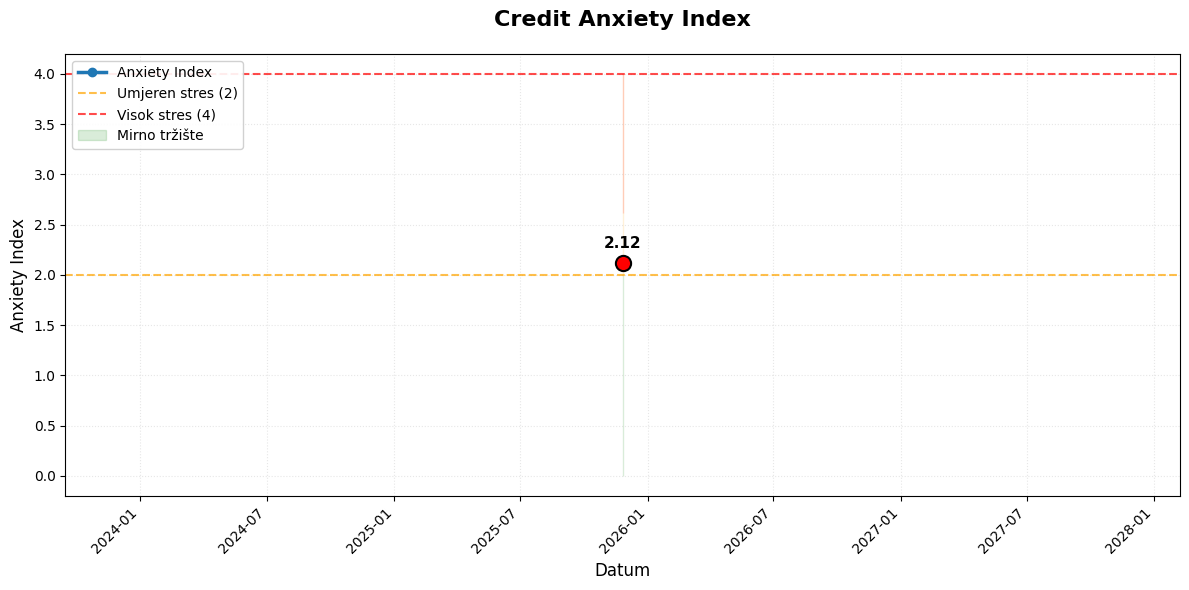

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

# glavna linija
ax.plot(hist['observation_date'], hist['anxiety_index'], 
        marker='o', linewidth=2.5, markersize=6,
        color='#1f77b4', label='Anxiety Index')

# threshold linije
ax.axhline(y=2, color='orange', linestyle='--', linewidth=1.5, 
           alpha=0.7, label='Umjeren stres (2)')
ax.axhline(y=4, color='red', linestyle='--', linewidth=1.5, 
           alpha=0.7, label='Visok stres (4)')

# bojanje zona
max_idx = hist['anxiety_index'].max()
ax.fill_between(hist['observation_date'], 0, 2, 
                alpha=0.15, color='green', label='Mirno tržište')
ax.fill_between(hist['observation_date'], 2, 4, 
                alpha=0.15, color='orange')
ax.fill_between(hist['observation_date'], 4, max_idx + 0.5, 
                alpha=0.15, color='red')

# Označi zadnju vrijednost
last_date = hist['observation_date'].iloc[-1]
last_val = hist['anxiety_index'].iloc[-1]
ax.scatter(last_date, last_val, s=120, color='red', 
           zorder=5, edgecolor='black', linewidth=1.5)
ax.text(last_date, last_val + 0.15, f'{last_val:.2f}', 
        ha='center', fontsize=11, fontweight='bold')

# Styling
ax.set_title('Credit Anxiety Index', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Datum', fontsize=12)
ax.set_ylabel('Anxiety Index', fontsize=12)
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(alpha=0.3, linestyle=':', linewidth=0.8)

# Rotacija x-osi
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("anxiety.png", dpi=150, bbox_inches='tight')
plt.show()